In [371]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from scipy.interpolate import interp1d
import seaborn as sns
pd.options.mode.chained_assignment = None  # default='warn'

In [153]:
def add_new_year(Year):
    #DOB Filter empty year
    dead = pd.read_fwf('./deces-' + str(Year) + '.txt',widths=(80,1,8,5,30,30,8,5),header=0,names=('NomPrenom','Sexe','DOB','CodeLieuxNaissance','AdressseNaissance','Etranger','DOD','CodeLieuDeces'), encoding= 'unicode_escape')
    dead.drop(dead[dead['DOB']/10**7%10==0].index,inplace=True)
    dead.drop(dead[dead['DOB']/10**6%10==0].index,inplace=True)    
    #DOB Filter empty day and force 00 to 01
    dead['DOB'] = np.where((dead['DOB']%10==0) & (dead['DOB']/10%10==0), dead['DOB'] + 1, dead['DOB'])
    #DOB Filter empty month and force 00 to 01
    dead['DOB'] = np.where((np.trunc(dead['DOB']/100%10)==0) & (np.trunc(dead['DOB']/1000%10)==0), dead['DOB'] + 100, dead['DOB'])
    
    #DOD Filter empty year
    dead.drop(dead[dead['DOD']<19000101].index,inplace=True)
    dead.drop(dead[dead['DOD']/10**7%10==0].index,inplace=True)
    dead.drop(dead[dead['DOD']/10**6%10==0].index,inplace=True)    
    #DOD Filter empty day and force 00 to 01
    dead['DOD'] = np.where((dead['DOD']%10==0) & (dead['DOD']/10%10==0), dead['DOD'] + 1, dead['DOD'])
    #DOD Filter empty month and force 00 to 01
    dead['DOD'] = np.where((np.trunc(dead['DOD']/100%10)==0) & (np.trunc(dead['DOD']/1000%10)==0), dead['DOD'] + 100, dead['DOD'])
    
    #Remove '/' in Col 1
    dead.iloc[:,0]=dead.iloc[:,0].str[:-1]
    #Split Name * Col 1
    dead[['Last','First']] = dead.NomPrenom.str.split("*",expand=True)
    dead.drop(columns='NomPrenom',inplace=True)
    # shift column to first position
    first = dead.pop('Last')
    second = dead.pop('First')

    dead.insert(0, 'Last', first)
    dead.insert(0, 'First', second)
    #Change format DOB, DOD
    dead["DOB"] = pd.to_datetime(dead["DOB"], yearfirst=True, errors='coerce', dayfirst=False, format="%Y%m%d")
    dead["DOD"] = pd.to_datetime(dead["DOD"], yearfirst=True, dayfirst=False, format="%Y%m%d")
    dead["Age"]= (dead["DOD"] - dead["DOB"])/np.timedelta64(1,'Y')
    dead.drop(dead[dead['Age']>130].index,inplace=True)
    dead.drop(dead[dead['Age']<=0].index,inplace=True)
    
    #Corse exeption 2A, 2B
    if dead['CodeLieuxNaissance'].dtype!='int64':
        dead['CodeLieuxNaissance'] = np.where(dead['CodeLieuxNaissance'].isnull()==True,00000, dead['CodeLieuxNaissance'])
        dead['CodeLieuxNaissance'] = np.where(dead['CodeLieuxNaissance'].str[:-3]=='2B',20200, dead['CodeLieuxNaissance'])
        dead['CodeLieuxNaissance'] = np.where(dead['CodeLieuxNaissance'].str[:-3]=='2A',20000, dead['CodeLieuxNaissance'])
    if dead['CodeLieuDeces'].dtype!='int64':
        dead['CodeLieuDeces'] = np.where(dead['CodeLieuDeces'].isnull()==True,00000, dead['CodeLieuDeces'])
        dead['CodeLieuDeces'] = np.where(dead['CodeLieuDeces'].str[:-3]=='2B',20200, dead['CodeLieuDeces'])
        dead['CodeLieuDeces'] = np.where(dead['CodeLieuDeces'].str[:-3]=='2A',20000, dead['CodeLieuDeces'])
    dead=dead.astype({'CodeLieuxNaissance': 'int64', 'CodeLieuDeces':'int64'})
    #Departement Naissance
    dead['DEP_B'] = np.trunc(dead['CodeLieuxNaissance']/1000)
    dead=dead.astype({'DEP_B': 'int64'})
    
    return dead

In [154]:
dead=add_new_year(2010)

In [155]:
dead.corr()

,Sexe,CodeLieuxNaissance,CodeLieuDeces,Age,DEP_B
Sexe,1.000000,-0.017295,-0.003681,0.240559,-0.017235
CodeLieuxNaissance,-0.017295,1.000000,0.433865,-0.053552,0.999982
CodeLieuDeces,-0.003681,0.433865,1.000000,-0.048877,0.433672
Age,0.240559,-0.053552,-0.048877,1.000000,-0.053360
DEP_B,-0.017235,0.999982,0.433672,-0.053360,1.000000


In [156]:
#dead.to_csv('1999.csv')

In [157]:
dead.describe()

,Sexe,CodeLieuxNaissance,CodeLieuDeces,Age,DEP_B
count,549744.000000,549744.000000,549744.000000,549738.000000,549744.000000
mean,1.488957,58320.032350,52493.948038,77.080567,58.092150
std,0.499878,28421.792348,27360.027809,16.389639,28.417297
min,1.000000,0.000000,0.000000,0.002738,0.000000
25%,1.000000,34301.000000,30189.000000,68.902168,34.000000
50%,1.000000,61148.000000,56260.000000,81.474637,61.000000
75%,2.000000,78551.000000,75116.000000,88.267384,78.000000
max,2.000000,99514.000000,99990.000000,112.443103,99.000000


In [147]:
dead['CodeLieuxNaissance'].isnull().value_counts()

False    549734
True         10
Name: CodeLieuxNaissance, dtype: int64

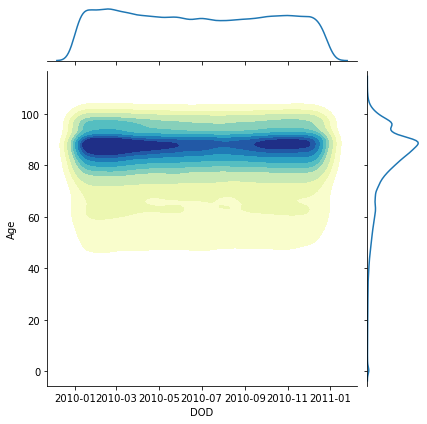

In [177]:
ALL_FILTERED=dead[(dead['DOD'].dt.year>2009) & (dead['Sexe']==2)]
sns.jointplot(x='DOD',y='Age',data=ALL_FILTERED, kind='kde',shade=True,cmap='YlGnBu')

In [174]:
(dead['DOD'].dt.year>2000) & (dead['Sexe']==1)

0          True
1          True
2         False
3          True
4          True
          ...  
551009    False
551010    False
551011    False
551012     True
551013     True
Length: 549744, dtype: bool

In [161]:
All_deads = pd.DataFrame()
for i in np.arange(1971,2022,2):
    print(i)
    New_year = pd.DataFrame()
    New_year=add_new_year(i)    
    All_deads=pd.concat([All_deads,New_year]).reset_index(drop=True)
All_deads.head()

1971
1973
1975
1977
1979
1981
1983
1985
1987
1989
1991
1993
1995
1997
1999
2001
2003
2005
2007
2009
2011
2013
2015
2017
2019
2021


,First,Last,Sexe,DOB,CodeLieuxNaissance,AdressseNaissance,Etranger,DOD,CodeLieuDeces,Age,DEP_B
0,JOANNY,PERRUCHET,1,1905-08-08,1001,L'ABERGEMENT-CLEMENCIAT,NaN,1971-03-10,71270,65.586562,1
1,JEANNE MARIE,RIGAUD,2,1908-08-05,1001,L'ABERGEMENT-CLEMENCIAT,NaN,1971-02-18,1446,62.539272,1
2,ANTOINETTE,GUICHARD,2,1913-04-26,1001,L'ABERGEMENT-CLEMENCIAT,NaN,1971-05-23,1028,58.073746,1
3,JEAN CLAUDE,BOUCHY,1,1894-09-30,1001,L'ABERGEMENT-CLEMENCIAT,NaN,1971-02-18,69384,76.384868,1
4,MICHEL,GAUTHIER,1,1899-09-22,1001,L'ABERGEMENT-CLEMENCIAT,NaN,1971-07-23,1028,71.831728,1


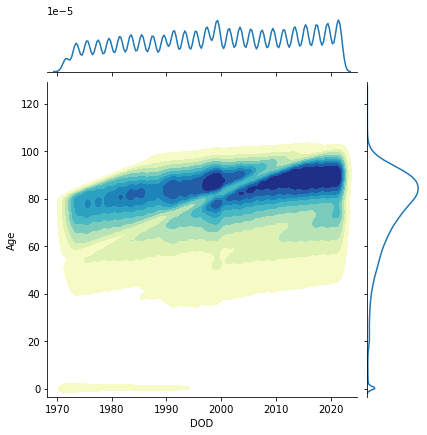

In [163]:
ALL_FILTERED=All_deads[All_deads['DOD'].dt.year>1970]
sns.jointplot(x='DOD',y='Age',data=ALL_FILTERED, kind='kde',shade=True,cmap='YlGnBu')

In [179]:
All_deads.dtypes

First                         object
Last                          object
Sexe                           int64
DOB                   datetime64[ns]
CodeLieuxNaissance             int64
AdressseNaissance             object
Etranger                      object
DOD                   datetime64[ns]
CodeLieuDeces                  int64
Age                          float64
DEP_B                          int64
dtype: object

In [203]:
All_deads.corr()

,Sexe,CodeLieuxNaissance,CodeLieuDeces,Age,DEP_B
Sexe,1.000000,-0.012205,0.000069,0.235086,-0.012168
CodeLieuxNaissance,-0.012205,1.000000,0.467858,-0.025062,0.999981
CodeLieuDeces,0.000069,0.467858,1.000000,-0.046052,0.467650
Age,0.235086,-0.025062,-0.046052,1.000000,-0.024913
DEP_B,-0.012168,0.999981,0.467650,-0.024913,1.000000


(60.0, 90.0)

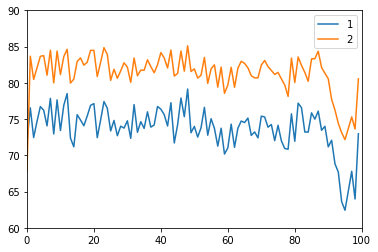

In [193]:
ALL_FILTERED=All_deads[All_deads['DOD'].dt.year>1970]
DEP=pd.pivot_table(ALL_FILTERED,index=["Sexe","DEP_B"],values=["Age"],aggfunc=[np.mean])

DEP2=DEP['mean']
DEP3=pd.pivot_table(dead,index=["DEP_B"],columns='Sexe',values=["Age"])
plt.plot(DEP3)
plt.legend([1,2])
plt.xlim(0,100)
plt.ylim(60,90)

C:\ProgramData\Anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


6.0    1942179
0.0    1941168
5.0    1913802
3.0    1893502
4.0    1890633
1.0    1882930
2.0    1880047
Name: DOB, dtype: int64

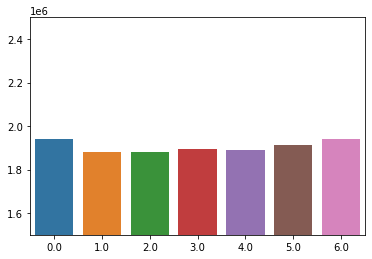

In [198]:
Day=ALL_FILTERED['DOB'].dt.dayofweek.value_counts()
sns.barplot(Day.index,Day.values)
plt.gca().set_ylim(1500000, 2500000)
Day

C:\ProgramData\Anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


1     1282567
12    1240421
3     1181877
2     1126561
10    1117007
11    1107642
4     1088170
5     1076864
7     1044115
8     1041138
6     1026800
9     1011123
Name: DOD, dtype: int64

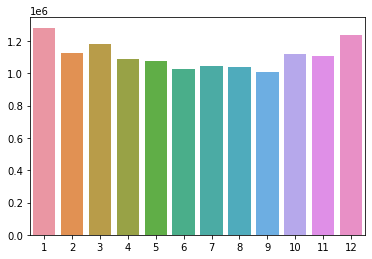

In [202]:
Month=ALL_FILTERED['DOD'].dt.month.value_counts()
sns.barplot(Month.index,Month.values)
#plt.gca().set_ylim(25000, 45000)
Month

In [51]:
Meuf2021=dead_2021[dead_2021['Sexe']==2]
Kem2021=dead_2021[dead_2021['Sexe']==1]

sns.histplot(Meuf2021['Age'],kde=True,color="y")
sns.histplot(Kem2021['Age'],kde=True,color="r")

Meuf1975=dead_1975[dead_1975['Sexe']==2]
Kem1975=dead_1975[dead_1975['Sexe']==1]

sns.histplot(Meuf1975['Age'],kde=True,color="g")
sns.histplot(Kem1975['Age'],kde=True,color="b")
      

NameError: name 'dead_2021' is not defined

In [ ]:
sns.scatterplot(x=dead_2021['DOB_AAAA'],y=dead_2021['Age'],hue=dead_2021['Sexe'],palette='YlGnBu')

In [ ]:
sns.boxplot(x='DOB_AAAA',y='Age',data=All_deads, hue='Sexe', palette='YlGnBu')

In [97]:
#All_deads=pd.concat([dead_1975,dead_1985,dead_1995,dead_2005,dead_2021]).reset_index(drop=True)

<AxesSubplot:xlabel='DOB_AAAA', ylabel='Age'>

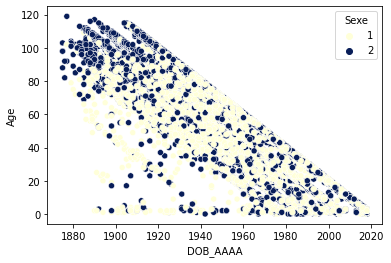

In [115]:
sns.scatterplot(x=All_deads['DOB_AAAA'],y=All_deads['Age'],hue=All_deads['Sexe'],palette='YlGnBu')

<AxesSubplot:xlabel='DOB_AAAA', ylabel='Age'>

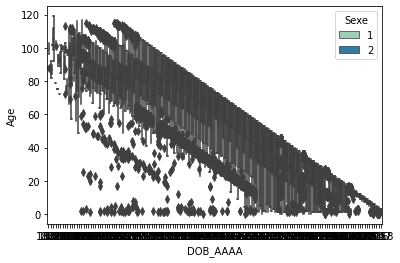

In [116]:
sns.boxplot(x='DOB_AAAA',y='Age',data=All_deads, hue='Sexe', palette='YlGnBu')

<AxesSubplot:xlabel='DOB_AAAA', ylabel='Age'>

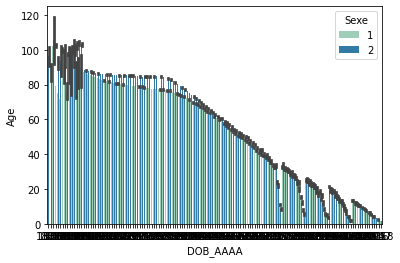

In [117]:
sns.barplot(x='DOB_AAAA',y='Age',data=All_deads, hue='Sexe', palette='YlGnBu')

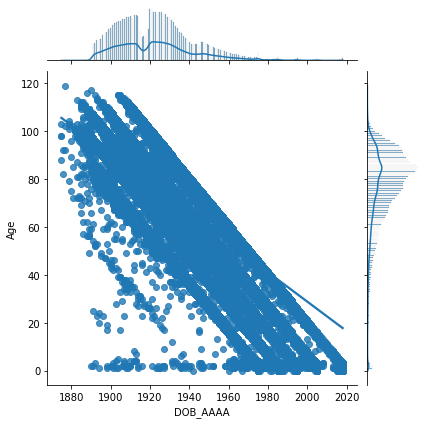

In [118]:
sns.jointplot(x='DOB_AAAA',y='Age',data=All_deads, kind='reg')

In [ ]:
sns.jointplot(x='DOB_AAAA',y='Age',data=All_deads, kind='kde')

In [114]:
Day=dead_1975['DOD'].dt.dayofweek.value_counts()

Days=pd.DataFrame([dead_1975['DOD'].dt.dayofweek.value_counts(),dead_1980['DOD'].dt.dayofweek.value_counts(),dead_1985['DOD'].dt.dayofweek.value_counts(),dead_1990['DOD'].dt.dayofweek.value_counts(),dead_1995['DOD'].dt.dayofweek.value_counts(),dead_2000['DOD'].dt.dayofweek.value_counts(),dead_2005['DOD'].dt.dayofweek.value_counts(),dead_2010['DOD'].dt.dayofweek.value_counts(),dead_2015['DOD'].dt.dayofweek.value_counts(),dead_2020['DOD'].dt.dayofweek.value_counts()], index=[1975,1980,1985,1990,1995,2000,2005,2010,2015,2020])
#sns.barplot(x='DOB_AAAA',y='Age',data=All_deads, hue='Sexe', palette='YlGnBu')
Days
DaysT=Days.transpose()
DaysT

,1975,1980,1985,1990,1995,2000,2005,2010,2015,2020
0,57713,63061,69020,79386,75912,82345,80561,79496,88150,97908
1,56643,63813,69087,78191,75605,82229,80183,79520,88290,98224
2,58270,63793,67652,77805,74318,81271,79523,78734,87028,97190
3,56777,61804,67573,77648,74730,81062,79883,78770,86843,97575
4,56845,62488,67438,78516,74833,81594,79678,79223,87550,98255
5,56705,61648,67278,78283,73849,81153,78947,77389,86871,95782
6,55727,60887,66328,76811,72170,79931,77522,76612,84089,94298


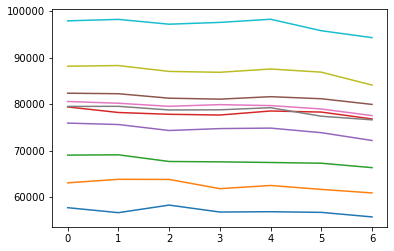

In [115]:
plt.plot(DaysT)

In [121]:
Month=dead_1975['DOD'].dt.month.value_counts()

Months=pd.DataFrame([dead_1975['DOD'].dt.month.value_counts(),dead_1980['DOD'].dt.month.value_counts(),dead_1985['DOD'].dt.month.value_counts(),dead_1990['DOD'].dt.month.value_counts(),dead_1995['DOD'].dt.month.value_counts(),dead_2000['DOD'].dt.month.value_counts(),dead_2005['DOD'].dt.month.value_counts(),dead_2010['DOD'].dt.month.value_counts(),dead_2015['DOD'].dt.month.value_counts(),dead_2020['DOD'].dt.month.value_counts()], index=[1975,1980,1985,1990,1995,2000,2005,2010,2015,2020])
#sns.barplot(x='DOB_AAAA',y='Age',data=All_deads, hue='Sexe', palette='YlGnBu')
MonthsT=Months.transpose()
MonthsT

,1975,1980,1985,1990,1995,2000,2005,2010,2015,2020
1,38409,40402,49178,57682,49680,61777,50491,52621,59569,58146
2,31049,35315,40478,44774,41857,49638,51942,47056,58490,52038
3,34196,35708,43993,46080,47310,46978,55300,48813,56070,63858
4,33442,36602,39064,44756,46672,44134,45121,44968,48713,67638
5,32934,36756,39112,43019,44756,43578,44454,45286,47207,49773
6,31383,34317,35902,41757,42443,42231,42583,42442,45656,46874
7,32099,35781,37275,44212,44696,43712,41469,43238,47811,47910
8,32811,34170,35568,43679,42846,42813,40714,42400,47557,50008
9,30682,32761,33609,40855,41483,41061,40518,42369,45888,50070
10,33923,37122,38012,45303,42996,47117,44301,46534,51234,58888


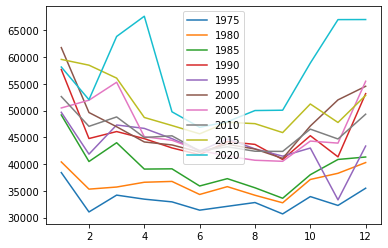

In [129]:
plt.plot(MonthsT)
plt.legend([1975,1980,1985,1990,1995,2000,2005,2010,2015,2020])

In [150]:
Pivot1=All_deads.pivot_table(index=All_deads['DOB'].dt.month, columns='Sexe', values='Age')

In [151]:
Pivot1[0:30]

Sexe,1,2
DOB,,
1.0,70.735265,78.786087
2.0,70.758838,79.040479
3.0,70.745486,78.965645
4.0,70.644538,78.909396
5.0,70.290033,78.675513
6.0,70.223591,78.603018
7.0,70.109657,78.571664
8.0,70.251603,78.719584
9.0,70.324830,78.769988


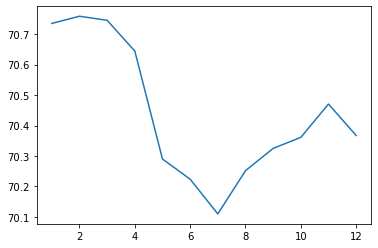

In [152]:
#Pivot1T=Pivot1.transform
plt.plot(Pivot1[1])

In [153]:
Pivot2=All_deads.pivot_table(index=All_deads['Last'], columns='Sexe', values='Age')

In [177]:
Pivot2.index

Index(['', '-BAILLEST', '-BARBAZANGE', '-BERNARD', '-BEYNAT', '-BIAU',
       '-BOUVIER', '-BROCHARD', '-FOURCADE', '-LANDOIS',
       ...
       'ZYWIEC', 'ZYWIECKA', 'ZYWIECKI', 'ZYWINA', 'ZYWIOLEK', 'ZYWOCKI',
       'ZYZANSKI', 'ZYZEK', 'ZYZNOWSKI', 'ZYZYNSKI'],
      dtype='object', name='Last', length=502625)

MARTIN               17025
BERNARD               9169
THOMAS                8061
PETIT                 7880
DURAND                7530
                     ...  
MYCAK                    1
JACQUAINT                1
NICOLAU-BERTHELON        1
BALAU                    1
PAIXAO                   1
Name: Last, Length: 502626, dtype: int64

In [159]:
Toto=All_deads['Last'].value_counts()

In [167]:
Toto.iloc[0:10].index

Index(['MARTIN', 'BERNARD', 'THOMAS', 'PETIT', 'DURAND', 'DUBOIS', 'RICHARD',
       'ROBERT', 'MOREAU', 'LAURENT', 'MICHEL', 'SIMON', 'LEFEBVRE', 'LEROY',
       'ROUX', 'BERTRAND', 'DAVID', 'FOURNIER', 'BONNET', 'GIRARD', 'MOREL',
       'BLANC', 'FAURE', 'LAMBERT', 'VINCENT', 'ROUSSEAU', 'DUPONT', 'ANDRE',
       'MULLER', 'MERCIER', 'GARNIER', 'GUERIN', 'LEFEVRE', 'GAUTHIER',
       'FRANCOIS', 'CHEVALIER', 'LEGRAND', 'PERRIN', 'FONTAINE', 'ROBIN',
       'CLEMENT', 'MATHIEU', 'NICOLAS', 'BOYER', 'ROUSSEL', 'HENRY', 'MORIN',
       'MASSON', 'MARCHAND', 'GARCIA'],
      dtype='object')

In [195]:
Pivot2.loc[Toto.iloc[0:50].index]

Sexe,1,2
MARTIN,71.176555,79.597134
BERNARD,71.214659,79.225335
THOMAS,70.994329,79.406906
PETIT,70.789064,78.813487
DURAND,72.007738,80.020890
DUBOIS,70.399747,78.684765
RICHARD,70.380432,78.963043
ROBERT,70.386046,79.017771
MOREAU,71.408318,79.895666
LAURENT,71.103717,79.014286


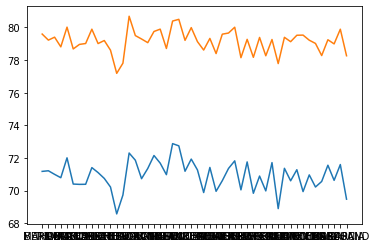

In [198]:
plt.plot(Pivot2.loc[Toto.iloc[0:50].index])

In [200]:
All_deads

,First,Last,Sexe,DOB,CodeLieuxNaissance,AdressseNaissance,Etranger,DOD,CodeLieuDeces,ActeDecesNumber,Age
0,CLEMENT ANTOINE,THOUNY,1,1904-08-31,1001,L'ABERGEMENT-CLEMENCIAT,NaN,1975-09-25,1001,3,71.067852
1,JEAN ADOLPHE,MAZUY,1,1905-07-03,1001,L'ABERGEMENT-CLEMENCIAT,NaN,1975-11-03,1004,4,70.336831
2,CELINE,LONGIN,2,1907-03-26,1001,L'ABERGEMENT-CLEMENCIAT,NaN,1975-08-05,1146,1,68.362800
3,MARTHE MARIE,BATAILLARD,2,1914-09-04,1001,L'ABERGEMENT-CLEMENCIAT,NaN,1975-11-27,1335,1,61.230552
4,FRANCOISE,RICHONNIER,2,1896-02-27,1001,L'ABERGEMENT-CLEMENCIAT,NaN,1975-08-23,1265,9,79.484178
...,...,...,...,...,...,...,...,...,...,...,...
4792537,JEAN-LOUIS ANDRE ALBERT,FOURNIER,1,1957-08-05,75118,PARIS 18E ARRONDISSEMENT,NaN,2020-02-09,99134,2162,62.514631
4792538,KAMEL,CHITOUR,1,1941-07-27,93352,DEPARTEMENT DE CONSTANTINE,NaN,2020-09-11,99134,2166,79.128250
4792539,WALTRAUD ROSINA,SCHOTTMULLER,2,1930-02-18,99109,LAHR,ALLEMAGNE,2020-11-11,99134,2165,90.731500
4792540,ANDRE CHARLES,MASSONNET,1,1943-10-01,01060,BRENOD,NaN,2020-09-29,99140,3588,76.998159


In [205]:
PivotEtranger=All_deads.pivot_table(index=All_deads['CodeLieuxNaissance'], columns='Sexe', values='Age')

In [206]:
PivotEtranger[0:100]

Sexe,1,2
CodeLieuxNaissance,,
1001,70.007806,80.080529
1002,87.457876,83.276727
1003,67.103363,83.066045
1004,61.938153,74.925389
1005,77.834216,80.546144
...,...,...
1096,71.844181,79.474498
1097,68.326112,80.113897
1098,72.656447,82.928009


In [216]:
#sns.barplot(x='DOD',y='Age',data=All_deads, hue='Sexe', palette='YlGnBu')

<AxesSubplot:xlabel='Sexe', ylabel='Age'>

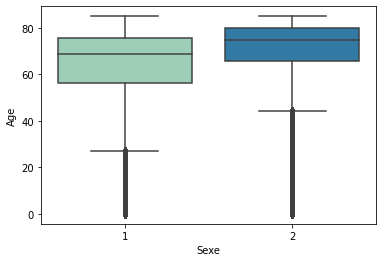

In [215]:
sns.boxplot(x=dead_1975['Sexe'],y=dead_1975['Age'],palette='YlGnBu')

In [220]:
def plot_mortality_year(Year):
    #DOB Filter empty year
    dead = pd.read_fwf('./deces-' + str(Year) + '.txt',widths=(80,1,8,5,30,30,8,5,9),header=0,names=('NomPrenom','Sexe','DOB','CodeLieuxNaissance','AdressseNaissance','Etranger','DOD','CodeLieuDeces','ActeDecesNumber'), encoding= 'unicode_escape')
    dead.drop(dead[dead['DOB']/10**7%10==0].index,inplace=True)
    dead.drop(dead[dead['DOB']/10**6%10==0].index,inplace=True)    
    #DOB Filter empty day and force 00 to 01
    dead['DOB'] = np.where((dead['DOB']%10==0) & (dead['DOB']/10%10==0), dead['DOB'] + 1, dead['DOB'])
    #DOB Filter empty month and force 00 to 01
    dead['DOB'] = np.where((np.trunc(dead['DOB']/100%10)==0) & (np.trunc(dead['DOB']/1000%10)==0), dead['DOB'] + 100, dead['DOB'])
    
    #DOD Filter empty year
    dead.drop(dead[dead['DOD']<19000101].index,inplace=True)
    dead.drop(dead[dead['DOD']/10**7%10==0].index,inplace=True)
    dead.drop(dead[dead['DOD']/10**6%10==0].index,inplace=True)    
    #DOD Filter empty day and force 00 to 01
    dead['DOD'] = np.where((dead['DOD']%10==0) & (dead['DOD']/10%10==0), dead['DOD'] + 1, dead['DOD'])
    #DOD Filter empty month and force 00 to 01
    dead['DOD'] = np.where((np.trunc(dead['DOD']/100%10)==0) & (np.trunc(dead['DOD']/1000%10)==0), dead['DOD'] + 100, dead['DOD'])
    
    #Remove '/' in Col 1
    dead.iloc[:,0]=dead.iloc[:,0].str[:-1]
    #Split Name * Col 1
    dead[['Last','First']] = dead.NomPrenom.str.split("*",expand=True)
    dead.drop(columns='NomPrenom',inplace=True)
    # shift column to first position
    first = dead.pop('Last')
    second = dead.pop('First')

    dead.insert(0, 'Last', first)
    dead.insert(0, 'First', second)
    #Change format DOB, DOD
    dead["DOB"] = pd.to_datetime(dead["DOB"], yearfirst=True, errors='coerce', dayfirst=False, format="%Y%m%d")
    dead["DOD"] = pd.to_datetime(dead["DOD"], yearfirst=True, dayfirst=False, format="%Y%m%d")
    dead["Age"]= (dead["DOD"] - dead["DOB"])/np.timedelta64(1,'Y')
    dead.drop(dead[dead['Age']>130].index,inplace=True)
    dead.drop(dead[dead['Age']<=0].index,inplace=True)
    #Meuf=dead[dead['Sexe']==2]
    #Kem=dead[dead['Sexe']==1]
    #Mortality_plt=sns.histplot(Kem['Age'],bins=120,color="blue")
    #Mortality_plt=sns.histplot(Meuf['Age'],bins=120,color="m")
    #Mortality_plt.set(xlim=(0,120),ylim=(0, 15000))
    #Mortality_plt.set_title('Mortality year: ' + str(Year))
    #plt.savefig('./mortality_' + str(Year) + '.png')  
    #plt.clf()
    Box_plt2=sns.boxplot(x=dead['Sexe'],y=dead['Age'],palette='YlGnBu')
    Box_plt2.set(ylim=(20,120))
    Box_plt2.set_title('Mortality year: ' + str(Year))
    plt.savefig('./Box_plot2_' + str(Year) + '.png')  
    plt.clf()
    
    return dead

In [221]:
for i in np.arange(1970,2022,5):
    plot_mortality_year(i)


<Figure size 432x288 with 0 Axes>

In [222]:
#df.drop('New',axis=1,inplace=True)
#ans7a_ = ans6a.isnull().sum()
All_deads.isnull().sum()

First                       0
Last                        0
Sexe                        0
DOB                         8
CodeLieuxNaissance          0
AdressseNaissance        5385
Etranger              4377464
DOD                         0
CodeLieuDeces             282
ActeDecesNumber          2920
Age                         8
dtype: int64

In [303]:
EXP=pd.pivot_table(All_deads,index="DOD",values="Age",aggfunc=np.mean)
EXP=EXP[EXP.index.year>1970]
EXP.index.year

Int64Index([1971, 1971, 1971, 1971, 1971, 1971, 1971, 1971, 1971, 1971,
            ...
            2020, 2020, 2020, 2020, 2020, 2020, 2020, 2020, 2020, 2020],
           dtype='int64', name='DOD', length=10488)

<AxesSubplot:xlabel='DOD', ylabel='Age'>

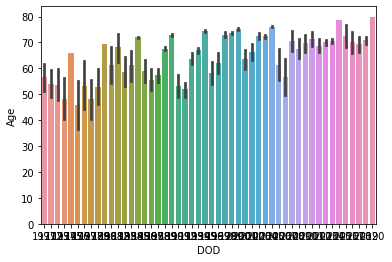

In [304]:
sns.barplot(x=EXP.index.year,y=EXP['Age'])

In [307]:
ALL_FILTERED=All_deads[All_deads['DOD'].dt.year>1970]

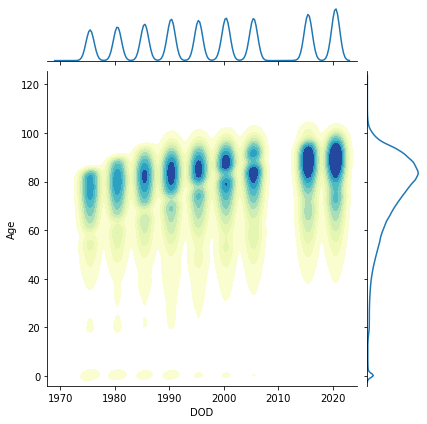

In [314]:
sns.jointplot(x='DOD',y='Age',data=ALL_FILTERED, kind='kde',shade=True,cmap='YlGnBu')

In [213]:
COVID = pd.DataFrame()
for i in np.arange(2018,2022,1):
    print(i)
    COVID=pd.concat([COVID,add_new_year(i)]).reset_index(drop=True)
COVID.head()

2018
2019
2020
2021


,First,Last,Sexe,DOB,CodeLieuxNaissance,AdressseNaissance,Etranger,DOD,CodeLieuDeces,Age,DEP_B
0,SIMONE PERINA,BONNEVIE,2,1924-07-28,69386,LYON 6E ARRONDISSEMENT,NaN,2018-01-16,1004,93.472145,69
1,THERESE,FOREST,2,1927-01-19,69382,LYON 2E ARRONDISSEMENT,NaN,2018-01-18,1004,90.999815,69
2,JEAN MARIE NOEL CANDIDE,PERNET,1,1938-12-10,1269,NANTUA,NaN,2018-01-23,1004,79.122775,1
3,BLANCHE,PERRIN,2,1923-02-26,69387,LYON 7E ARRONDISSEMENT,NaN,2018-01-20,1004,94.901333,69
4,SUZANNE MARIE GEORGETTE,CHRISTIN,2,1933-10-08,1411,SOUCLIN,NaN,2017-05-14,1004,83.599253,1


In [214]:
COVID.drop(columns=['First','Last','AdressseNaissance'], axis=1 ,inplace=True)

In [215]:
COVID

,Sexe,DOB,CodeLieuxNaissance,Etranger,DOD,CodeLieuDeces,Age,DEP_B
0,2,1924-07-28,69386,NaN,2018-01-16,1004,93.472145,69
1,2,1927-01-19,69382,NaN,2018-01-18,1004,90.999815,69
2,1,1938-12-10,1269,NaN,2018-01-23,1004,79.122775,1
3,2,1923-02-26,69387,NaN,2018-01-20,1004,94.901333,69
4,2,1933-10-08,1411,NaN,2017-05-14,1004,83.599253,1
...,...,...,...,...,...,...,...,...
2593953,1,1958-09-10,99330,GUINEE,2021-12-06,99330,63.240176,99
2593954,1,1946-12-31,99350,MAROC,2021-09-05,99350,74.681889,99
2593955,1,1946-07-01,75075,NaN,2021-11-28,99217,75.412911,75
2593956,1,1977-06-28,77055,NaN,2021-09-02,99327,44.181605,77


In [216]:
Month=COVID['DOD'].dt.month.value_counts()

(array([1., 2., 2., 0., 1., 1., 2., 0., 1., 2.]),
 array([186691. , 192805.8, 198920.6, 205035.4, 211150.2, 217265. ,
        223379.8, 229494.6, 235609.4, 241724.2, 247839. ]),
 <BarContainer object of 10 artists>)

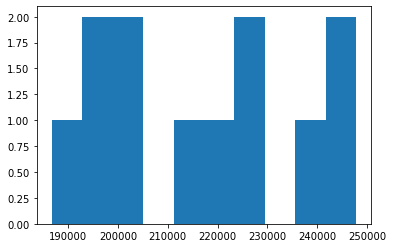

In [218]:
plt.hist(Month)

In [219]:
Month_2=pd.pivot_table(COVID,index="DOD",values="Age",aggfunc=np.mean)

In [220]:
Month_2

,Age
DOD,
1900-02-12,0.106778
1900-02-28,0.062972
1900-03-10,0.002738
1900-03-18,0.123206
1900-03-29,0.024641
...,...
2021-12-26,80.854427
2021-12-27,80.690762
2021-12-28,81.874309


In [221]:
Year=ALL_FILTERED

In [222]:
Year['DOD']=Year['DOD'].dt.year

In [329]:
Year2=pd.pivot_table(Year,index=['Sexe','DOD'],values='Age',aggfunc=[np.mean,np.max])
Year2

mean        amax
                 Age         Age
Sexe DOD                        
1    1971  55.581986   86.320732
     1972  56.568735   90.460448
     1973  61.807105   91.221586
     1974  51.624044   90.356407
     1975  63.636757   95.191551
...              ...         ...
2    2017  82.808914  117.209799
     2018  82.189266  111.309609
     2019  83.051078  114.521174
     2020  82.715434  110.767504
     2021  83.182829  125.415306

[102 rows x 2 columns]

In [330]:
#Year2=pd.pivot_table(Year,index=['Sexe','DOD'],values='Age',aggfunc=[np.mean,np.max])
#Year2

X=Year2.loc[(2,slice(None)),('mean','Age')]
ttt=pd.DataFrame(X)

#plt.plot(X)
#plt.plot(Year2.loc[(2,slice(None)),('mean','Age')])

#plt.plot(Year2.loc[(1,slice(None)),('amax','Age')])
#plt.plot(Year2.loc[(2,slice(None)),('amax','Age')])

#plt.ylim(20,130)

In [355]:
Kem=pd.pivot_table(Year[Year['Sexe']==1],index='DOD',values='Age',aggfunc=[np.mean,np.max])
Meuf=pd.pivot_table(Year[Year['Sexe']==2],index='DOD',values='Age',aggfunc=[np.mean,np.max])

In [357]:
Meuf.values[:,1]

array([ 95.85960013,  85.67732397,  92.98753568,  97.13272689,
        94.27982779,  96.29492734, 102.71805718,  96.33052013,
       100.70843344, 101.58182577, 101.37374484,  99.48732691,
       102.2964195 , 101.39291019, 103.36694114, 108.00495561,
       110.39514843,  99.75837971, 109.13844911, 121.96554344,
       112.69225241, 109.75447819, 114.92364662, 107.96388701,
       118.18996968, 109.00155376, 122.45015298, 112.35001403,
       120.10102877, 109.34653005, 115.11530011, 107.57510421,
       115.12898964, 107.85984654, 114.47189196, 114.46915406,
       117.18789571, 116.28986221, 119.33715271, 114.71556569,
       113.39863242, 111.29044402, 122.57062089, 110.64429797,
       121.2865425 , 109.25344121, 117.20979897, 111.30960937,
       114.52117429, 110.76750378, 125.41530627])

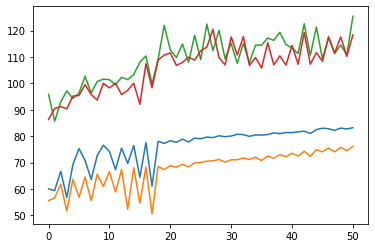

In [359]:
plt.plot(Meuf.values[:,0])
plt.plot(Kem.values[:,0])
plt.plot(Meuf.values[:,1])
plt.plot(Kem.values[:,1])

In [378]:
sns.scatterplot(x=Kem.index,y=Kem.values[:,0],'-')
sns.scatterplot(x=Kem.index,y=Kem.values[:,1])
sns.scatterplot(x=Meuf.index,y=Meuf.values[:,0])
sns.scatterplot(x=Meuf.index,y=Meuf.values[:,1])

SyntaxError: positional argument follows keyword argument (Temp/ipykernel_8872/3795673436.py, line 1)

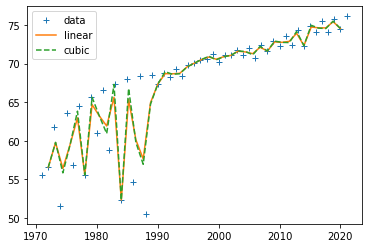

In [377]:
x = Kem.index
y = Kem.values[:,0]
f = interp1d(x, y)
f2 = interp1d(x, y, kind='cubic')
xnew = np.linspace(1972, 2020, num=41, endpoint=True)
plt.plot(x, y, '+', xnew, f(xnew), '-', xnew, f2(xnew), '--')
plt.legend(['data', 'linear', 'cubic'], loc='best')
plt.show()

In [384]:
Month=ALL_FILTERED['DOD']
Month

0           1971
1           1971
2           1971
3           1971
4           1971
            ... 
13348608    2021
13348609    2021
13348610    2021
13348611    2021
13348612    2021
Name: DOD, Length: 13344285, dtype: int64

In [ ]:
sns.lineplot(data=flights, x="year", y="passengers", hue="month")